In [1]:
from helpers import *

import shutil


import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from collections import OrderedDict
from itertools import product



linestyles = OrderedDict(
    [

     ('loosely dashed',      (0, (5, 20))),
     ('dashed',              (0, (3, 2))),
     ('densely dashed',      (0, (1, 3))),

    ])

# Data Processing

## Importing data

In [2]:
def load_kaggle_data(path):
    data = pd.read_csv(path)
    data.replace({'\\N':np.nan}, inplace=True)
    return data

data_dir ='kaggle-data/'

circuits_raw_df = load_kaggle_data(f'{data_dir}/circuits.csv')
constructors_raw_df = load_kaggle_data(f'{data_dir}/constructors.csv')
constructor_standings_raw_df = load_kaggle_data(f'{data_dir}/constructor_standings.csv')
driver_standings_raw_df = load_kaggle_data(f'{data_dir}/driver_standings.csv')
drivers_raw_df = load_kaggle_data(f'{data_dir}/drivers.csv')
laptimes_raw_df = load_kaggle_data(f'{data_dir}/lap_times.csv')
pitstops_raw_df = load_kaggle_data(f'{data_dir}/pit_stops.csv')
qualifying_raw_df = load_kaggle_data(f'{data_dir}/qualifying.csv')
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
seasons_raw_df = load_kaggle_data(f'{data_dir}/seasons.csv')
sprint_results = load_kaggle_data(f'{data_dir}/sprint_results.csv')
status_raw_df = load_kaggle_data(f'{data_dir}/status.csv')

# print('circuits_raw_df', circuits_raw_df.columns)
# print('constructors_raw_df', constructors_raw_df.columns)
# print('constructor_standings_raw_df', constructor_standings_raw_df.columns)
# print('driver_standings_raw_df', driver_standings_raw_df.columns)
# print('drivers_raw_df', drivers_raw_df.columns)
# print('laptimes_raw_df', laptimes_raw_df.columns)
# print('pitstops_raw_df', pitstops_raw_df.columns)
# print('qualifying_raw_df', qualifying_raw_df.columns)
# print('races_raw_df', races_raw_df.columns)
# print('results_raw_df', results_raw_df.columns)
# print('seasons_raw_df', seasons_raw_df.columns)
# print('sprint_results', sprint_results.columns)
# print('status_raw_df', status_raw_df.columns)

## Merge to get race data

In [3]:
# Driver name
drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
drivers.drop(['forename','surname'], axis=1, inplace=True)


# start with race results
# extend positionText labels (see Appendix)
results_raw_df['positionText'] = results_raw_df['positionText'].replace({'R':'Retired','D':'Disqualified','N':'not classified', 'E':'Excluded','W':'Withdrawn','F':'failed to qualify'})
# drop time, milliseconds, fastestLap, rank, fastestLapTime, fastestLapSpeed, and number (http://ergast.com/mrd/methods/results/)
races = results_raw_df.drop(['time','milliseconds','fastestLap','rank','fastestLapTime','fastestLapSpeed','number'], axis=1)
races.drop(['positionOrder'], axis=1, inplace=True)
races['position'].fillna('NaN', inplace=True)
#display(races.isna().sum())
assert races.isna().sum().sum() == 0, 'there are null values'

# Get race data (ignoring qualifying data)
races_raw_df.rename(columns={'name':'Race'}, inplace=True)
prev_len = races.shape[0]
races = races.merge(races_raw_df[['raceId','Race','round','circuitId','date','url']], on='raceId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0

# Explode date
races['date'] = pd.to_datetime(races['date'])
races['Month'] = races['date'].dt.month
races['Year'] = races['date'].dt.year
#races.drop(['date'], axis=1, inplace=True)

# Filter year due to bad quality data in early years (multiple results reported for a driver in a race) -- see EDA for details
races = races[races['Year']>1964].reset_index(drop=True)
assert races.groupby(['raceId','driverId'])['position'].nunique().max()==1, 'there are multiple positions reported for a driver in a race'

# Merge with drivers
prev_len = races.shape[0]
races = races.merge(drivers[['driverId','Name']], on='driverId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Name'].isna().sum() == 0


# # Filter for drivers of interest
# races = races[races['Name'].isin(driver_names_of_interest)].reset_index(drop=True)
# assert races['driverId'].nunique() == len(driver_ids_of_interest), 'confirm we have lap data for all drivers of interest'
# #races.drop(['driverId'], axis=1, inplace=True)
# assert races.groupby(['raceId','Name']).size().max() == 1, 'driver occurs twice in a race'
# assert races.groupby(['raceId','driverId'])['position'].nunique().max() == 1


# Get status string
prev_len = races.shape[0]
races = races.merge(status_raw_df[['statusId','status']], on='statusId', how='left')
assert races['status'].isna().sum() == 0
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
races.drop(['statusId'], axis=1, inplace=True)


# Get car name
prev_len = races.shape[0]
constructors_raw_df.rename(columns={'name':'Car'}, inplace=True)
car_names = constructors_raw_df['Car'].unique()
races = races.merge(constructors_raw_df[['constructorId','Car']], on='constructorId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Car'].isna().sum() == 0
races.drop(['constructorId'], axis=1, inplace=True)


# Get circuit data
prev_len = races.shape[0]
circuits_raw_df.rename(columns={'name':'Circuit'}, inplace=True)
circuits_raw_df['alt'].fillna(circuits_raw_df['alt'].median(), inplace=True) # impute median altitude -- #todo may want to change
races = races.merge(circuits_raw_df[['circuitId','Circuit','location','country','alt','lat','lng']], on='circuitId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0
races.drop(['circuitId'], axis=1, inplace=True)

# Get number of laps in the race
number_of_laps = results_raw_df[results_raw_df['statusId']==1].groupby(['raceId'])['laps'].max().reset_index(name='nlaps')
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
prev_len = races.shape[0]
races = races.merge(number_of_laps, on='raceId',how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
races.drop(['laps'], axis=1, inplace=True)



# Summary
print('First year:',  races['Year'].min())
print('# Races:', races['raceId'].nunique())

First year: 1965
# Races: 960


### Filter for drivers with lap times (since those the drivers in the model)

In [4]:
laptimes = laptimes_raw_df[laptimes_raw_df['raceId'].isin(races['raceId'].unique())].reset_index(drop=True)[['raceId','driverId','lap','position','milliseconds']]
drivers = laptimes['driverId'].unique()

#prev_len = laptimes.shape[0]
races = races[races['driverId'].isin(drivers)].reset_index(drop=True)
print('# Races:', races['raceId'].nunique())

# Races: 700


### More filters

In [5]:
# remove driver/race entries where the driver didn't finish for whatever reason
races['position'] = races['position'].astype(float)
races = races[races['position'].notnull()].reset_index(drop=True)


# remove races where there was only one driver, since we want to best capture relative performance
prev_n_races = races['raceId'].nunique()
race_counts = races['raceId'].value_counts()
valid_races = race_counts[race_counts > 1].index
races = races[races['raceId'].isin(valid_races)].reset_index(drop=True)
print('Races removed:', prev_n_races - races['raceId'].nunique())

# Limitation -- imbalance of drivers

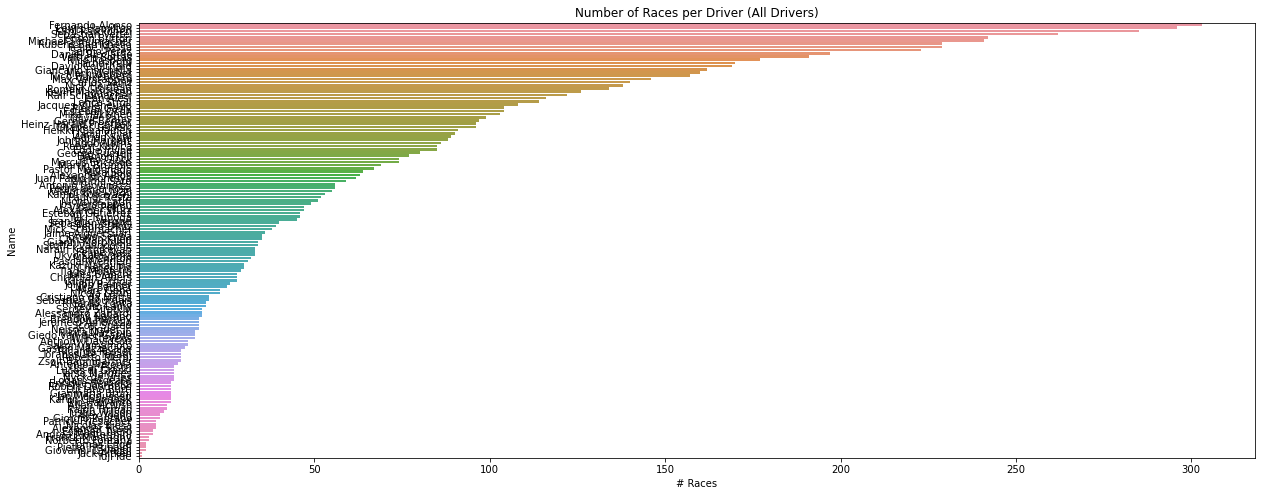

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))
title = 'Number of Races per Driver (All Drivers)'
plt.title(title)
driver_n_races = races.groupby('Name').size().sort_values(ascending=False).reset_index(name='# Races')

sns.barplot(data=driver_n_races, x='# Races', y='Name')

plt.savefig(f'eda_visualizations/{title}.png')

# Models for driver feature

In [76]:
model_data = races.copy(deep=True)
X, y = model_data.drop(['position'], axis=1), model_data['position']

#X.drop(['raceId','resultId','positionText','points','status','lat','lng','location','country','Race','Circuit'], axis=1, inplace=True)

### Base model -- just driver

In [34]:
def driver_only_linear(data, y, col='Name'):
    data = data[col]
    data = pd.get_dummies(data, columns=[col], drop_first=False)
    X = data.values

    #y = (y == 1).astype(int)

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

name_baseline_coef = driver_only_linear(X, y)
driverId_baseline_coef = driver_only_linear(X, y, col='driverId')
name_baseline_coef

,Adrian Sutil,Alessandro Zanardi,Alex Yoong,Alexander Albon,Alexander Rossi,Alexander Wurz,Allan McNish,Andrea Montermini,Anthony Davidson,Antonio Giovinazzi,Antônio Pizzonia,Brendon Hartley,Bruno Senna,Carlos Sainz,Charles Leclerc,Charles Pic,Christian Klien,Christijan Albers,Cristiano da Matta,Damon Hill,Daniel Ricciardo,Daniil Kvyat,David Coulthard,Eddie Irvine,Enrique Bernoldi,Esteban Gutiérrez,Esteban Ocon,Esteban Tuero,Felipe Massa,Felipe Nasr,Fernando Alonso,Franck Montagny,Gastón Mazzacane,George Russell,Gerhard Berger,Giancarlo Fisichella,Gianmaria Bruni,Gianni Morbidelli,Giedo van der Garde,Giorgio Pantano,Giovanni Lavaggi,Guanyu Zhou,Heikki Kovalainen,Heinz-Harald Frentzen,Jack Aitken,Jacques Villeneuve,Jaime Alguersuari,Jan Magnussen,Jarno Trulli,Jean Alesi,Jean-Éric Vergne,Jenson Button,Johnny Herbert,Jolyon Palmer,Jos Verstappen,Juan Pablo Montoya,Jules Bianchi,Justin Wilson,Jérôme d'Ambrosio,Kamui Kobayashi,Karun Chandhok,Kazuki Nakajima,Kevin Magnussen,Kimi Räikkönen,Lance Stroll,Lando Norris,Lewis Hamilton,Logan Sargeant,Luca Badoer,Lucas di Grassi,Luciano Burti,Marc Gené,Marcus Ericsson,Mark Webber,Martin Brundle,Max Chilton,Max Verstappen,Michael Schumacher,Mick Schumacher,Mika Häkkinen,Mika Salo,Narain Karthikeyan,Nelson Piquet Jr.,Nicholas Latifi,Nick Heidfeld,Nico Hülkenberg,Nico Rosberg,Nicola Larini,Nicolas Kiesa,Nikita Mazepin,Norberto Fontana,Nyck de Vries,Olivier Panis,Oscar Piastri,Pascal Wehrlein,Pastor Maldonado,Patrick Friesacher,Paul di Resta,Pedro Diniz,Pedro Lamy,Pedro de la Rosa,Pierre Gasly,Pietro Fittipaldi,Ralf Schumacher,Ralph Firman,Ricardo Rosset,Ricardo Zonta,Rio Haryanto,Robert Doornbos,Robert Kubica,Roberto Merhi,Romain Grosjean,Rubens Barrichello,Sakon Yamamoto,Scott Speed,Sebastian Vettel,Sergey Sirotkin,Sergio Pérez,Shinji Nakano,Stoffel Vandoorne,Sébastien Bourdais,Sébastien Buemi,Takuma Sato,Tarso Marques,Tiago Monteiro,Timo Glock,Tomáš Enge,Toranosuke Takagi,Ukyo Katayama,Valtteri Bottas,Vitaly Petrov,Vitantonio Liuzzi,Will Stevens,Yuji Ide,Yuki Tsunoda,Zsolt Baumgartner
0,12.47191,10.277778,12.166667,10.079365,15.4,8.319149,10.875,9.75,14.285714,13.392857,9.909091,13.352941,13.885714,7.7,6.010417,17.3,11.228571,14.0,9.85,4.480519,8.324873,10.622222,5.828402,5.988235,11.444444,13.956522,9.375,12.5,7.266376,13.090909,6.184818,16.666667,12.538462,10.575,4.979381,8.228395,15.888889,10.294118,17.375,14.666667,12.5,13.107143,11.835165,6.520833,16.0,7.046296,12.083333,9.888889,9.470588,6.293103,11.911111,7.409091,7.795455,13.269231,10.530612,4.209677,16.571429,12.571429,17.882353,10.849057,17.222222,12.2,12.365079,6.238596,11.122807,8.139535,3.422297,15.9,11.6,17.6,10.222222,11.347826,13.918919,6.6,7.188406,17.34375,3.787671,3.701245,15.052632,4.466019,8.671875,17.181818,10.470588,15.431373,8.355072,9.910828,6.355932,11.086957,12.8,17.8125,10.666667,14.8,8.727273,11.2,15.0,12.80597,14.4,10.576923,9.358974,10.736842,12.339286,9.894231,18.0,6.254098,11.75,11.0,9.894737,18.222222,14.111111,9.423529,15.5,11.067164,7.056769,17.428571,12.294118,5.282443,14.833333,8.130045,10.5,12.088235,12.25,11.975,11.576271,12.7,13.344828,13.77027,13.0,11.666667,10.909091,6.732984,12.914894,13.818182,16.125,13.0,12.478261,13.5


In [29]:
# best driver according to base model
name_baseline_coef[name_baseline_coef.idxmin(axis=1)]

,Lewis Hamilton
0,3.422297


In [43]:
driverId_baseline_coef_df = pd.DataFrame(driverId_baseline_coef.T.reset_index().values, columns=['driverId','coef'])
driverId_baseline_coef_df['driverId'] = driverId_baseline_coef_df['driverId'].astype(int)

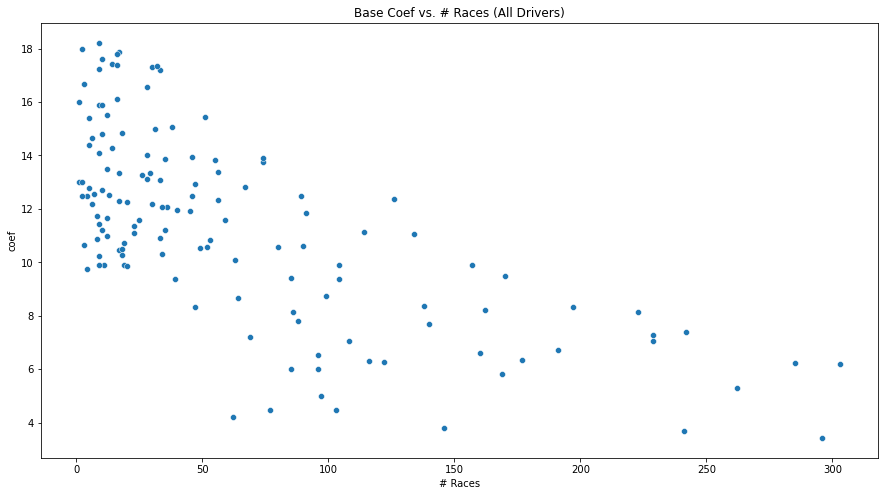

In [47]:
viz_data = races.groupby(['driverId']).size().reset_index(name='# Races').merge(driverId_baseline_coef_df, on='driverId', how='left')


fig, ax = plt.subplots(figsize=(15, 8))
title = 'Base Coef vs. # Races (All Drivers)'
plt.title(title)

sns.scatterplot(data=viz_data, x='# Races', y='coef')

plt.savefig(f'eda_visualizations/{title}.png')

In [83]:
def model2(features, y, col='driverId'):
    features = features[[col,'grid','Car','alt','Month','nlaps']]
    #data = data[[col,'grid','alt','nlaps']]
    features = pd.get_dummies(features, columns=[col, 'Car','Month'], drop_first=False)
    mm = MinMaxScaler()
    features[['grid','alt','nlaps']] = mm.fit_transform(features[['grid','alt','nlaps']])
    #display(data)
    X = features.values

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    weights = pd.DataFrame([coef], columns=features.columns)


    return weights

# name_model2_coef = model2(X, y, col='Name')
# driverId_model2_coef = model2(X, y, col='driverId')
# display(name_model2_coef)
# name_model2_coef_df = pd.DataFrame(name_model2_coef.T.reset_index().values, columns=['Name','coef'])
# #name_model2_coef_df['driverId'] = name_model2_coef_df['driverId'].astype(int)
# name_model2_coef_df = name_model2_coef_df[name_model2_coef_df['Name'].isin(model_data['Name'].unique())]
# name_model2_coef_df

driverId_model2_coef = model2(X, y, col='driverId')

driverId_model2_coef_df = pd.DataFrame(driverId_model2_coef.T.reset_index().values, columns=['driverId','coef'])
driverId_model2_coef_df = driverId_model2_coef_df[driverId_model2_coef_df['driverId'].str.contains("driverId")].reset_index(drop=True)
driverId_model2_coef_df['driverId'] = driverId_model2_coef_df['driverId'].str.replace('driverId_','').astype(int)
driverId_model2_coef_df

,driverId,coef
0,1,-610582240561.419067
1,2,-610582240559.782959
2,3,-610582240559.854004
3,4,-610582240560.773682
4,5,-610582240559.569336
...,...,...
131,854,-610582240556.753662
132,855,-610582240559.9104
133,856,-610582240555.231934
134,857,-610582240556.477905


In [84]:
# best driver according to model 2
name_model2_coef[name_model2_coef.idxmin(axis=1)]

,Car_Brawn
0,-2.639201e+12


In [103]:
def model3(features, y, col='driverId'):
    features = features[[col,'alt','nlaps']]
    features = pd.get_dummies(features, columns=[col,], drop_first=False)
    mm = MinMaxScaler()
    features[['alt','nlaps']] = mm.fit_transform(features[['alt','nlaps']])
    #display(data)
    X = features.values

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    weights = pd.DataFrame([coef], columns=features.columns)


    return weights

# name_model2_coef = model2(X, y, col='Name')
# driverId_model2_coef = model2(X, y, col='driverId')
# display(name_model2_coef)
# name_model2_coef_df = pd.DataFrame(name_model2_coef.T.reset_index().values, columns=['Name','coef'])
# #name_model2_coef_df['driverId'] = name_model2_coef_df['driverId'].astype(int)
# name_model2_coef_df = name_model2_coef_df[name_model2_coef_df['Name'].isin(model_data['Name'].unique())]
# name_model2_coef_df

driverId_model3_coef = model3(X, y, col='driverId')

driverId_model3_coef_df = pd.DataFrame(driverId_model3_coef.T.reset_index().values, columns=['driverId','coef'])
driverId_model3_coef_df = driverId_model3_coef_df[driverId_model3_coef_df['driverId'].str.contains("driverId")].reset_index(drop=True)
driverId_model3_coef_df['driverId'] = driverId_model3_coef_df['driverId'].str.replace('driverId_','').astype(int)
driverId_model3_coef_df['coef'] = driverId_model3_coef_df['coef'].astype(float)
driverId_model3_coef_df['scaled_coef'] = driverId_model3_coef_df['coef'] / driverId_model3_coef_df['coef'].abs().sum()
driverId_model3_coef_df.to_csv('data/driver_feature_model3_coef.csv', index=False)

In [104]:
# best driver according to model 3
driverId_model3_coef_df.sort_values(by='coef', ascending=True).head(10).merge(model_data[['driverId','Name']].drop_duplicates(), on='driverId', how='left')

,driverId,coef,scaled_coef,Name
0,1,4.092727,0.002507,Lewis Hamilton
1,30,4.405582,0.002698,Michael Schumacher
2,830,4.443480,0.002721,Max Verstappen
3,31,4.920114,0.003013,Juan Pablo Montoya
4,57,5.161649,0.003161,Mika Häkkinen
5,71,5.195983,0.003182,Damon Hill
6,77,5.685798,0.003482,Gerhard Berger
7,20,5.949614,0.003644,Sebastian Vettel
8,14,6.540364,0.004006,David Coulthard
9,844,6.655736,0.004076,Charles Leclerc


In [102]:
def model4(features, y, col='driverId'):
    features = features[[col,'alt','nlaps','country']]
    features = pd.get_dummies(features, columns=[col,'country'], drop_first=False)
    mm = MinMaxScaler()
    features[['alt','nlaps']] = mm.fit_transform(features[['alt','nlaps']])
    #display(data)
    X = features.values

    linreg = LinearRegression(fit_intercept=True)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    weights = pd.DataFrame([coef], columns=features.columns)


    return weights

driverId_model4_coef = model3(X, y, col='driverId')

driverId_model4_coef_df = pd.DataFrame(driverId_model4_coef.T.reset_index().values, columns=['driverId','coef'])
driverId_model4_coef_df = driverId_model4_coef_df[driverId_model4_coef_df['driverId'].str.contains("driverId")].reset_index(drop=True)
driverId_model4_coef_df['driverId'] = driverId_model4_coef_df['driverId'].str.replace('driverId_','').astype(int)
driverId_model4_coef_df['coef'] = driverId_model4_coef_df['coef'].astype(float)
driverId_model4_coef_df['scaled_coef'] = driverId_model4_coef_df['coef'] / driverId_model4_coef_df['coef'].abs().sum()
#driverId_model4_coef_df.to_csv('data/driver_feature_model4_coef.csv', index=False)
driverId_model4_coef_df

,driverId,coef,scaled_coef
0,1,-2.593902e+13,-0.007353
1,2,-2.593902e+13,-0.007353
2,3,-2.593902e+13,-0.007353
3,4,-2.593902e+13,-0.007353
4,5,-2.593902e+13,-0.007353
...,...,...,...
131,854,-2.593902e+13,-0.007353
132,855,-2.593902e+13,-0.007353
133,856,-2.593902e+13,-0.007353
134,857,-2.593902e+13,-0.007353
